# **Book Recommendation System**

## **Data Preprocessing**

1. Load the dataset into a suitable data structure (e.g., pandas DataFrame).  
2. Handle missing values, if any.       
3. Explore the dataset to understand its structure and attributes.
4. Use multiple visualizations to understand the hidden patterns in the dataset

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Suppress warnings
warnings.filterwarnings('ignore')

In [28]:
xls = pd.ExcelFile('/content/Bookshop.xlsx')
df_book = pd.read_excel(xls, 'Book')
df_author = pd.read_excel(xls, 'Author')
df_info = pd.read_excel(xls, 'Info')
df_award = pd.read_excel(xls, 'Award')
df_checkouts = pd.read_excel(xls, 'Checkouts')
df_edition = pd.read_excel(xls, 'Edition')
df_publisher = pd.read_excel(xls, 'Publisher')
df_ratings = pd.read_excel(xls, 'Ratings')
df_salesQ1 = pd.read_excel(xls, 'Sales Q1')
df_salesQ2 = pd.read_excel(xls, 'Sales Q2')
df_salesQ3 = pd.read_excel(xls, 'Sales Q3')
df_salesQ4 = pd.read_excel(xls, 'Sales Q4')

In [29]:
# Merging author details with book data
df_book1 = df_book.merge(df_author, on='AuthID', how='outer').drop(['First Name', 'Last Name', 'Birthday'], axis=1)

In [30]:
# Creating a unified BookID in df_info and merging with df_book1
df_info['BookID'] = df_info['BookID1'] + df_info['BookID2'].astype(str)
df_info.drop(['BookID1', 'BookID2'], axis=1, inplace=True)
df_book2 = df_book1.merge(df_info, on='BookID', how='outer').drop(['SeriesID', 'Volume Number', 'Staff Comment'], axis=1)

In [31]:
# Merging award data with the combined book info
df_book3 = df_book2.merge(df_award, on='Title', how='outer').drop(['Year Won'], axis=1)

In [32]:
# Aggregating monthly checkouts by BookID
df_checkouts_grouped = df_checkouts.groupby('BookID')['Number of Checkouts'].sum().reset_index()
df_book4 = df_book3.merge(df_checkouts_grouped, on='BookID', how='outer')

In [33]:
# Merging edition details with the book data
df_book5 = df_book4.merge(df_edition, on='BookID', how='outer').drop(['Format', 'Publication Date', 'Print Run Size (k)'], axis=1)

In [34]:
# Merging publisher details with book data
df_book6 = df_book5.merge(df_publisher, on='PubID', how='outer').drop(['Publishing House', 'City', 'State', 'Year Established'], axis=1)

In [35]:
# Merging ratings with book data
df_book7 = df_book6.merge(df_ratings, on='BookID', how='outer').drop(['ReviewID'], axis=1)

In [36]:
# Processing and combining sales data from all quarters
sales_dfs = [df_salesQ1, df_salesQ2, df_salesQ3, df_salesQ4]
for sales_df in sales_dfs:
    sales_df.fillna(0, inplace=True)

df_sales_combined = pd.concat([
    sales_df.groupby('ISBN')['Discount'].sum().reset_index() for sales_df in sales_dfs
], ignore_index=True)

df_sales_final = df_sales_combined.groupby('ISBN')['Discount'].sum().reset_index()

# Display combined sales data before merging
print("Combined Sales Data:")
print(df_sales_final.head())

df = df_book7.merge(df_sales_final, on='ISBN', how='outer')

Combined Sales Data:
                ISBN  Discount
0  989-28-229-0197-6     12.09
1  989-28-229-1404-4      8.06
2  989-28-229-3157-7     13.16
3  989-28-229-5891-8     25.25
4  989-28-229-6632-6     20.29


In [37]:
df.head()

,BookID,Title,AuthID,Country of Residence,Hrs Writing per Day,Genre,Award Name,Number of Checkouts,ISBN,PubID,Pages,Price,Country,Marketing Spend,Rating,ReviewerID,Discount
0,TO369,The Scent of Oranges,LD375,New Zealand,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,2.0,35.0,12.09
1,TO369,The Scent of Oranges,LD375,New Zealand,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,3.0,75.0,12.09
2,TO369,The Scent of Oranges,LD375,New Zealand,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,5.0,130.0,12.09
3,TO369,The Scent of Oranges,LD375,New Zealand,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,4.0,166.0,12.09
4,TO369,The Scent of Oranges,LD375,New Zealand,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,3.0,203.0,12.09


In [38]:
df.dropna(subset=['Number of Checkouts','ISBN','PubID','Pages','Price','Country','Marketing Spend','Rating','ReviewerID','Discount'],inplace=True)

In [39]:
df = df.drop('Country of Residence', axis=1)

In [40]:
# Display final merged DataFrame summary
print("Final merged DataFrame:")
df.head()

Final merged DataFrame:


,BookID,Title,AuthID,Hrs Writing per Day,Genre,Award Name,Number of Checkouts,ISBN,PubID,Pages,Price,Country,Marketing Spend,Rating,ReviewerID,Discount
0,TO369,The Scent of Oranges,LD375,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,2.0,35.0,12.09
1,TO369,The Scent of Oranges,LD375,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,3.0,75.0,12.09
2,TO369,The Scent of Oranges,LD375,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,5.0,130.0,12.09
3,TO369,The Scent of Oranges,LD375,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,4.0,166.0,12.09
4,TO369,The Scent of Oranges,LD375,8.0,Romance,NaN,161.0,989-28-229-0197-6,SSC,255.0,9.5,New Zealand,151000.0,3.0,203.0,12.09


In [41]:
df.columns

Index(['BookID', 'Title', 'AuthID', 'Hrs Writing per Day', 'Genre',
       'Award Name', 'Number of Checkouts', 'ISBN', 'PubID', 'Pages', 'Price',
       'Country', 'Marketing Spend', 'Rating', 'ReviewerID', 'Discount'],
      dtype='object')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92502 entries, 0 to 92502
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BookID               92502 non-null  object 
 1   Title                92502 non-null  object 
 2   AuthID               92502 non-null  object 
 3   Hrs Writing per Day  92502 non-null  float64
 4   Genre                92502 non-null  object 
 5   Award Name           39641 non-null  object 
 6   Number of Checkouts  92502 non-null  float64
 7   ISBN                 92502 non-null  object 
 8   PubID                92502 non-null  object 
 9   Pages                92502 non-null  float64
 10  Price                92502 non-null  float64
 11  Country              92502 non-null  object 
 12  Marketing Spend      92502 non-null  float64
 13  Rating               92502 non-null  float64
 14  ReviewerID           92502 non-null  float64
 15  Discount             92502 non-null  floa

In [43]:
# Checking if there is an null values in our dataset
df.isnull().sum()

,0
BookID,0
Title,0
AuthID,0
Hrs Writing per Day,0
Genre,0
Award Name,52861
Number of Checkouts,0
ISBN,0
PubID,0
Pages,0


In [44]:
# Replacing aal null or 'NaN' values in "Award" column with 'No Award'
df['Award Name'].fillna('No Award', inplace=True)

In [45]:
df.isnull().sum()

,0
BookID,0
Title,0
AuthID,0
Hrs Writing per Day,0
Genre,0
Award Name,0
Number of Checkouts,0
ISBN,0
PubID,0
Pages,0


In [46]:
df.describe()

,Hrs Writing per Day,Number of Checkouts,Pages,Price,Marketing Spend,Rating,ReviewerID,Discount
count,92502.000000,92502.000000,92502.000000,92502.000000,9.250200e+04,92502.000000,92502.000000,92502.000000
mean,6.349927,451.152029,422.043545,15.529925,1.387411e+06,4.173575,26688.627013,3.663931
std,2.271895,436.270629,300.100192,7.679380,1.102487e+06,0.931864,15352.608416,8.644354
min,0.000000,3.000000,11.000000,5.990000,4.800000e+04,1.000000,3.000000,0.000000
25%,5.000000,109.000000,255.000000,8.990000,7.200000e+04,4.000000,13338.000000,0.130000
50%,6.000000,246.000000,380.000000,12.500000,2.320000e+06,4.000000,26588.000000,0.780000
75%,8.000000,576.000000,640.000000,21.500000,2.320000e+06,5.000000,39958.750000,4.680000
max,13.000000,1332.000000,1296.000000,48.000000,2.320000e+06,5.000000,53424.000000,76.750000


<Axes: >

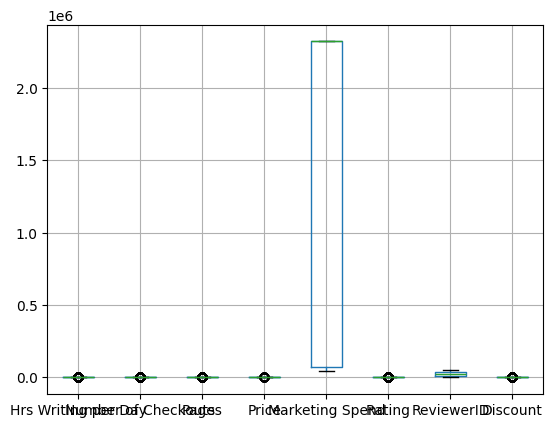

In [47]:
df.boxplot()

## **Visualization**

1. Create multiple plots to identify trends and patterns in the dataset.
2. Highlight relationships between key attributes.
3. Use charts to represent distributions and correlations visually.

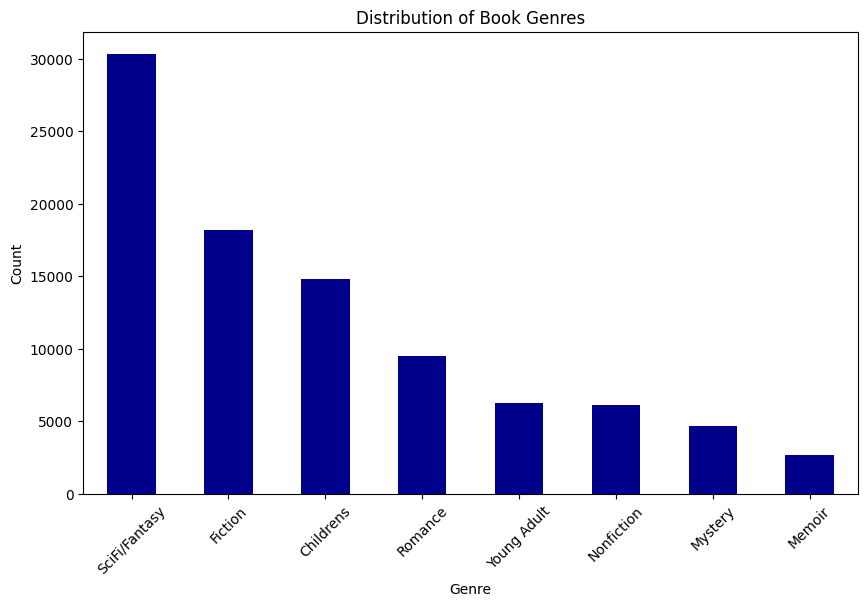

In [48]:
# Exploratory Data Analysis - Additional Visualizations
plt.figure(figsize=(10, 6))
df['Genre'].value_counts().plot(kind='bar', color='darkblue')
plt.title('Distribution of Book Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

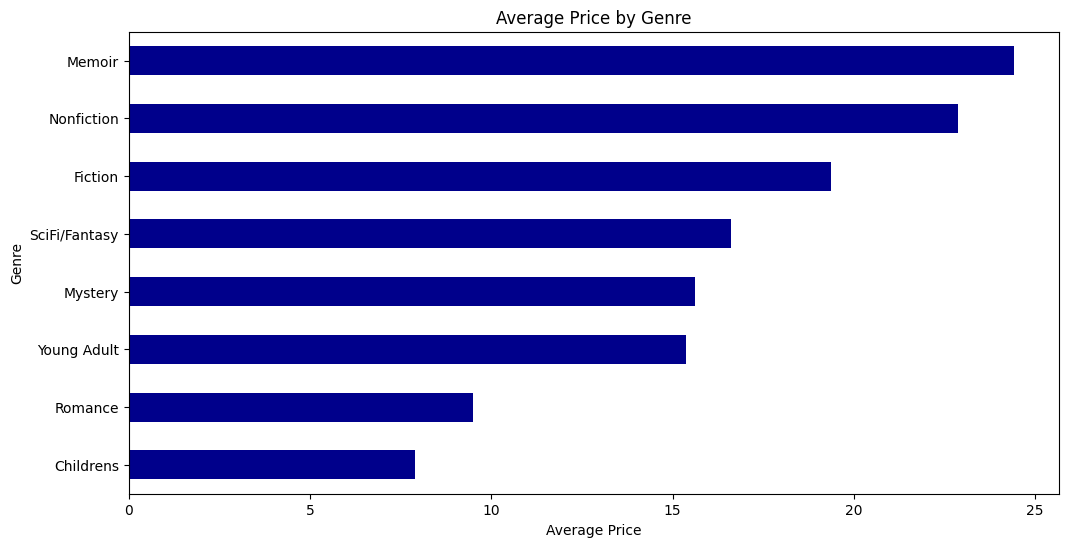

In [49]:
plt.figure(figsize=(12, 6))
df.groupby('Genre')['Price'].mean().sort_values().plot(kind='barh', color='darkblue')
plt.title('Average Price by Genre')
plt.xlabel('Average Price')
plt.ylabel('Genre')
plt.show()

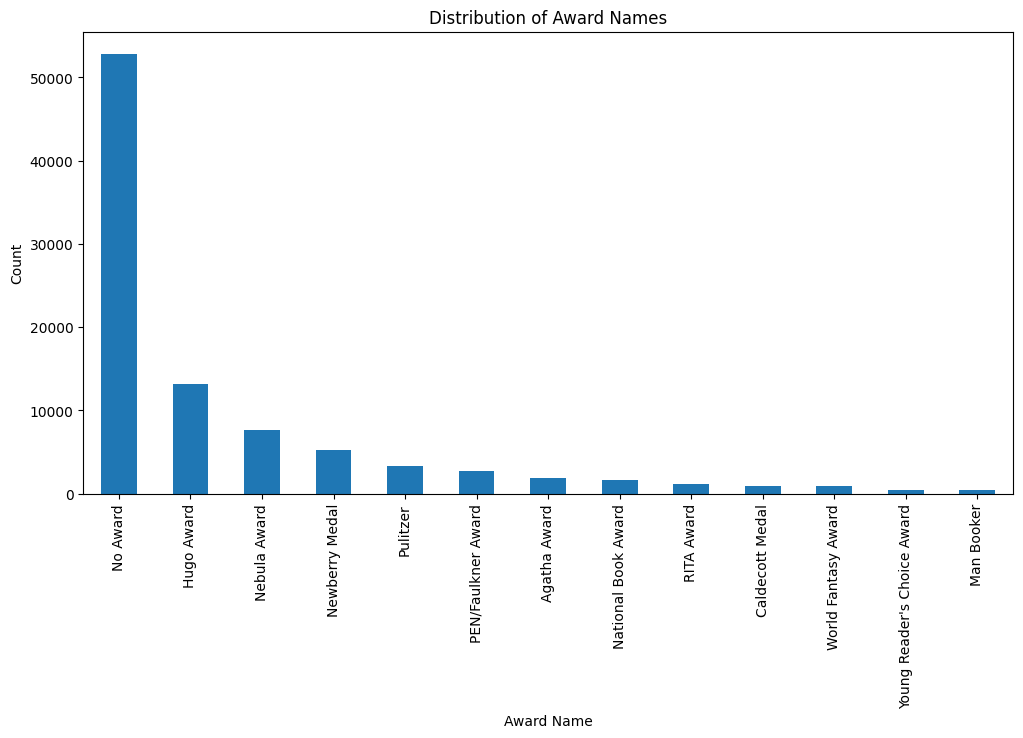

In [50]:
plt.figure(figsize=(12, 6))
df['Award Name'].value_counts().plot(kind='bar')
plt.title('Distribution of Award Names')
plt.xlabel('Award Name')
plt.ylabel('Count')
plt.show()

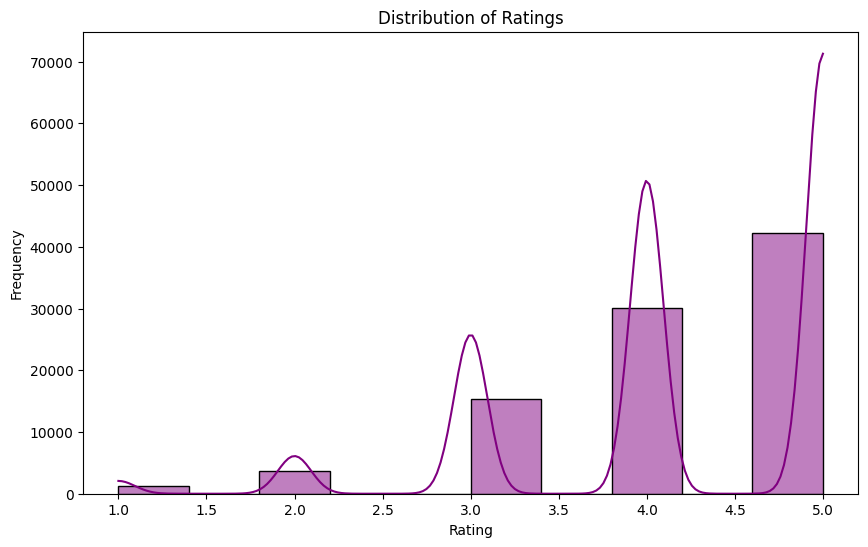

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'].dropna(), bins=10, color='purple', kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

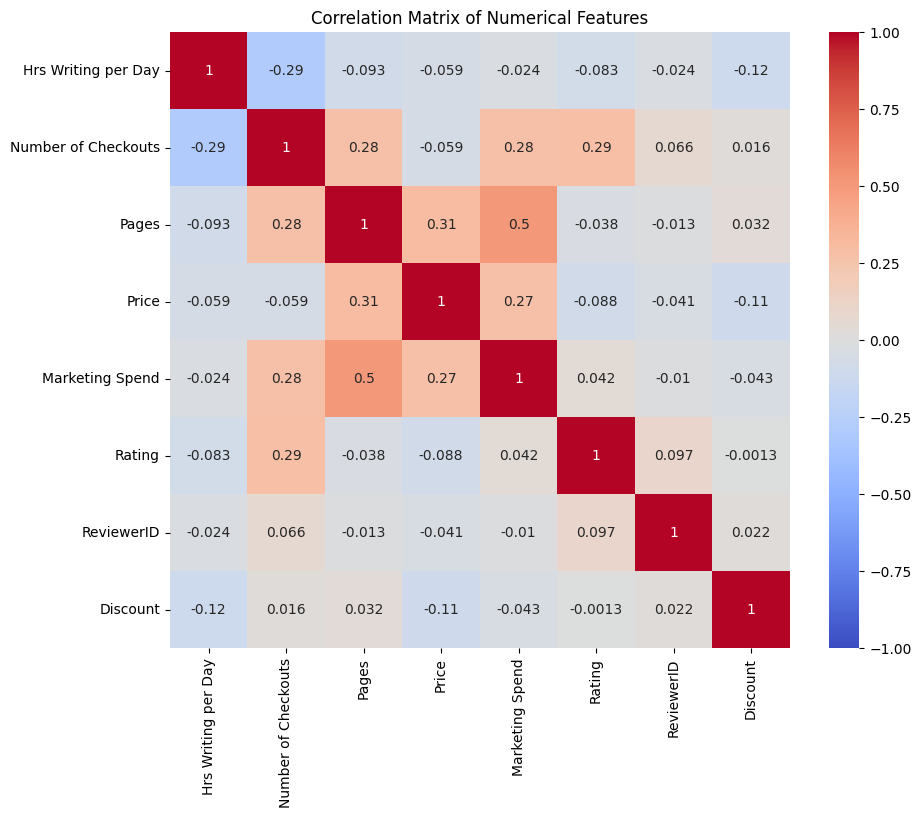

In [52]:
df_copy = df.copy()

# Selecting numerical columns for correlation analysis
numerical_columns = ['Hrs Writing per Day', 'Number of Checkouts', 'Pages',
                     'Price', 'Marketing Spend', 'Rating', 'ReviewerID', 'Discount']

# Converting relevant columns to numeric, ignoring errors to handle non-numeric data
df_copy[numerical_columns] = df_copy[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Creating the correlation matrix
correlation_matrix = df_copy[numerical_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


## **Feature Extarction**

1. Combine relevant features to create new interaction attributes.+
2. Encode categorical variables and normalize numerical data.
3. Handle missing values and remove irrelevant features.

In [53]:
import numpy as np

# Identify numerical columns
numerical_columns = ['Hrs Writing per Day', 'Number of Checkouts', 'Pages',
                     'Price', 'Marketing Spend', 'Rating', 'ReviewerID', 'Discount']

# Cap the outliers
for col in numerical_columns:
    # Calculate the IQR for each column
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers by setting values below the lower bound to the lower bound
    # and values above the upper bound to the upper bound
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Check the results
print("Capped Outliers in the DataFrame:")
print(df[numerical_columns].describe())

Capped Outliers in the DataFrame:
       Hrs Writing per Day  Number of Checkouts         Pages         Price  \
count         92502.000000         92502.000000  92502.000000  92502.000000   
mean              6.337003           450.091252    419.710439     15.521981   
std               2.199838           434.190077    293.531033      7.649731   
min               0.500000             3.000000     11.000000      5.990000   
25%               5.000000           109.000000    255.000000      8.990000   
50%               6.000000           246.000000    380.000000     12.500000   
75%               8.000000           576.000000    640.000000     21.500000   
max              12.500000          1276.500000   1217.500000     40.265000   

       Marketing Spend        Rating    ReviewerID      Discount  
count     9.250200e+04  92502.000000  92502.000000  92502.000000  
mean      1.387411e+06      4.213093  26688.627013      2.597442  
std       1.102487e+06      0.833564  15352.608416   

<Axes: >

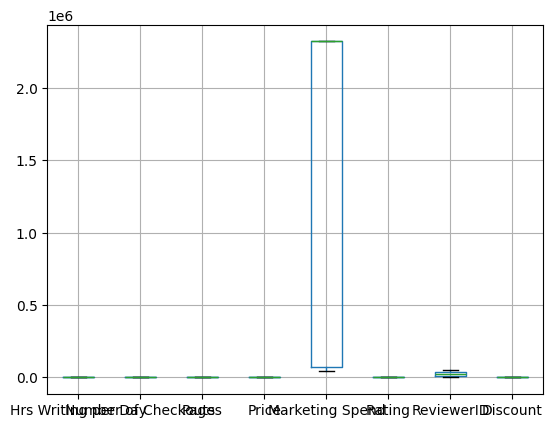

In [54]:
df.boxplot()

In [55]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[numerical_columns])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
cosine_sim = cosine_similarity(scaled_features)

In [ ]:
# Create a DataFrame for cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['BookID'], columns=df['BookID'])

In [ ]:
# Step 5: Recommend top N similar books for a given book (for example, BookID 'TO369')
book_id = 'TO369'  # Example book ID
similar_books = cosine_sim_df[book_id].sort_values(ascending=False)

In [ ]:
# Print the top 5 similar books
print("Top 5 similar books to", book_id)
print(similar_books.head(6))  # Includes the book itself at position 1